# this is all wrong

removed 600 rows with perturb=False and duplicate combinations


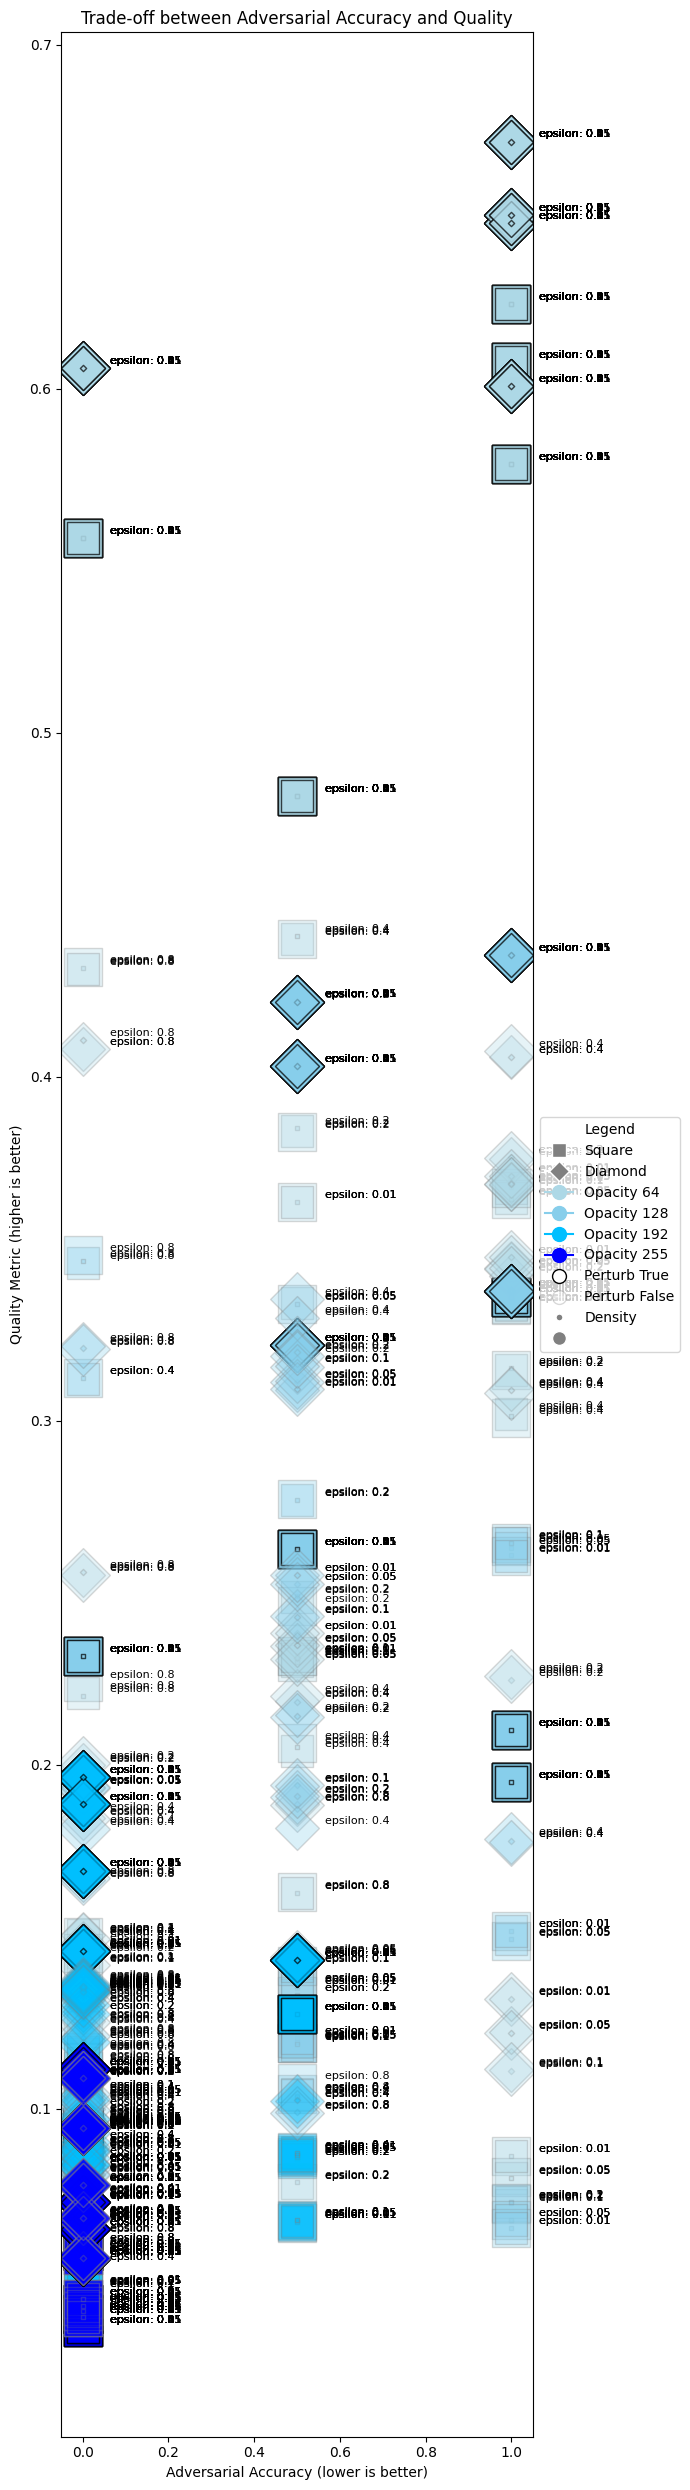

Top 10 results (lowest adversarial accuracy and highest quality):
       mask  opacity  density   quality  perturb  epsilon
1   diamond       64        1  0.605878     True     0.10
2   diamond       64       50  0.605878     True     0.05
3   diamond       64       50  0.605878     True     0.40
4   diamond       64       75  0.605878     True     0.20
5   diamond       64        1  0.605878     True     0.80
6   diamond       64       75  0.605878     True     0.80
7   diamond       64        1  0.605878     True     0.01
8   diamond       64        1  0.605878     True     0.20
9   diamond       64       50  0.605878     True     0.01
10  diamond       64       75  0.605878     True     0.05


In [3]:
import numpy as np
from pathlib import Path
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator


datapath = Path.cwd().parent / "data" / "eval" / "1-eval_cls_perturb.csv"
data = pd.read_csv(datapath)

data = data.drop(columns=['label'])

# filter rows where perturb is False and epsilon are different
filtered_data = data[data['perturb'] == False]
unique_combinations = filtered_data.groupby(['mask', 'opacity', 'density', 'perturb', 'img_id']).first().reset_index()
result = pd.concat([data[data['perturb'] == True], unique_combinations], ignore_index=True)
rows_removed = len(data) - len(result)
print(f"removed {rows_removed} rows with perturb=False and duplicate combinations")

# add util cols
data['adv_acc'] = ((data['advx_acc1'] + data['advx_acc5']) / 2) - (data['adv_acc1'] + data['adv_acc5']) / 2
data['quality'] = (data['cosine_sim'] + data['psnr'] / 100 + data['ssim']) / 3

plt.figure(figsize=(7, 25))

markers = {'square': 's', 'diamond': 'D'}
colors = {64: 'lightblue', 128: 'skyblue', 192: 'deepskyblue', 255: 'blue'}

for mask in markers:
    for opacity in colors:
        for perturb in [True, False]:
            mask_opacity_perturb_data = data[(data['mask'] == mask) & 
                                             (data['opacity'] == opacity) & 
                                             (data['perturb'] == perturb)]
            
            for _, row in mask_opacity_perturb_data.iterrows():
                plt.scatter(row['adv_acc'], row['quality'], 
                            marker=markers[mask], 
                            c=colors[opacity], 
                            s=row['density']*10,
                            alpha=0.7 if perturb else 0.3,
                            edgecolors='black' if perturb else 'gray')
                
                # add epsilon value as text next to each point
                plt.annotate(f"epsilon: {row['epsilon']}", 
                             (row['adv_acc'], row['quality']), 
                             xytext=(20, 3), 
                             textcoords='offset points', 
                             fontsize=8)

plt.xlabel('Adversarial Accuracy (lower is better)')
plt.ylabel('Quality Metric (higher is better)')
plt.title('Trade-off between Adversarial Accuracy and Quality')

legend_elements = [
    plt.Line2D([0], [0], marker='s', color='w', label='Square', markerfacecolor='gray', markersize=10),
    plt.Line2D([0], [0], marker='D', color='w', label='Diamond', markerfacecolor='gray', markersize=10),
    plt.Line2D([0], [0], marker='o', color='lightblue', label='Opacity 64', markersize=10),
    plt.Line2D([0], [0], marker='o', color='skyblue', label='Opacity 128', markersize=10),
    plt.Line2D([0], [0], marker='o', color='deepskyblue', label='Opacity 192', markersize=10),
    plt.Line2D([0], [0], marker='o', color='blue', label='Opacity 255', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', markeredgecolor='black', label='Perturb True', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', markeredgecolor='gray', label='Perturb False', markersize=10, alpha=0.3),
    plt.Line2D([0], [0], marker='o', color='w', label='Density', markerfacecolor='gray', markersize=5),
    plt.Line2D([0], [0], marker='o', color='w', label='', markerfacecolor='gray', markersize=10)
]

plt.legend(handles=legend_elements, title='Legend', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# -----

# from those with adv_acc == 0, get top 10 with highest quality
top_low_adv = data[data['adv_acc'] == 0].sort_values(by='quality', ascending=False).head(10)
top_low_adv = top_low_adv.reset_index(drop=True)
top_low_adv.index += 1

print("Top 10 results (lowest adversarial accuracy and highest quality):")
print(top_low_adv[['mask', 'opacity', 'density', 'quality', 'perturb', 'epsilon']])